# 1.0 Libraries For Preprocessing

In [30]:
# Library for Wrangling and loading
import pandas as pd
import numpy as np

# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Libraries for Partitioning and Spark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import shutil
import hashlib

# Others
import warnings
import os
import time

# Configuration
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

warnings.filterwarnings("ignore")

# 2.0 Partitioning

## 2.1 Partitioning Parameter

In [21]:
N_PARTITION = 50    # Number of buckets
base_partitions_dir = "../data/external/Partition"
output_dir = "../data/external/output"

## 2.2 Collecting data columns

In [20]:
# LOADING PARAMETER
chunksize= 1e5
data_directory = r"..\Data\external\used_cars_data.csv"
# loading chunk of the data for the column list
def col_list(data_path, chunksize, progress=None):
    print("Checking and loading file")
    time.sleep(0.9)
    for df_iter, chunk in enumerate(pd.read_csv(data_path, chunksize=chunksize, iterator=False)):
        pass
    col_list = list(chunk.columns)
    return col_list

## 2.3 Function for Hashing id

In [22]:
# hashing the listing id to allow even partitioning across the dataset
def hash_(listing_id):
    """Creates an hashed column using the listing id for the vehicle"""
    return int(hashlib.md5(str(listing_id).encode("utf-8")).hexdigest(), 16)

## 2.4 Creating dir for partition

In [23]:
def create_partition():
    """Creates an empty partition directory for the buckets"""
    start = time.time()
    print("Checking if the directory exists...")
    time.sleep(0.9)
    if os.path.exists(base_partitions_dir):
        print("Directory found")
        time.sleep(0.4)
        print("Removing directory")
        time.sleep(1)
        shutil.rmtree(base_partitions_dir)
        print("Removed the directory")
    else:
        print("No Such Directory found.")

    # Delaying before creating the directories
    time.sleep(2.5)

    print("Creating empty folder list for partition")
    time.sleep(0.9)
    if not os.path.exists(base_partitions_dir):
        # Creating partition directory
        os.mkdir(base_partitions_dir)
        # Making a new directory for the partitions
        for i in range(N_PARTITION):
            partition_path = os.path.join(
                base_partitions_dir, "p{}".format(i)).replace("\\", "/")
            # Printing the path
            print('| {} | Partition left {} |'.format(partition_path,N_PARTITION-i))
            if not os.path.exists(partition_path):
                os.mkdir(partition_path)
            else:
                print("Path Already exist")
            time.sleep(0.6)
    end = time.time()
    print("| Completed | Time Taken ------------------------- {}sec |".format(str(end-start)))
# Making the directory
dir = create_partition()


Checking if the directory exists...
Directory found
Removing directory
Removed the directory
Creating empty folder list for partition
| ../data/external/Partition/p0 | Partition left 50 |
| ../data/external/Partition/p1 | Partition left 49 |
| ../data/external/Partition/p2 | Partition left 48 |
| ../data/external/Partition/p3 | Partition left 47 |
| ../data/external/Partition/p4 | Partition left 46 |
| ../data/external/Partition/p5 | Partition left 45 |
| ../data/external/Partition/p6 | Partition left 44 |
| ../data/external/Partition/p7 | Partition left 43 |
| ../data/external/Partition/p8 | Partition left 42 |
| ../data/external/Partition/p9 | Partition left 41 |
| ../data/external/Partition/p10 | Partition left 40 |
| ../data/external/Partition/p11 | Partition left 39 |
| ../data/external/Partition/p12 | Partition left 38 |
| ../data/external/Partition/p13 | Partition left 37 |
| ../data/external/Partition/p14 | Partition left 36 |
| ../data/external/Partition/p15 | Partition left 3

## 2.5 Creating blank partition

In [24]:
chunksize= 1e5
data_directory = r"..\Data\external\used_cars_data.csv"
def create_blank_partition():
    """Creating a blank partition with the number of bucket"""
    start = time.time()
    data_list = col_list(data_directory, chunksize)
    for i in range(N_PARTITION):
        time.sleep(0.9)
        file_base_dir = os.path.join(base_partitions_dir,"p{}".format(str(i)),"").replace("\\","/")
        print(file_base_dir)
        # Opening the file and writing it to the partition created
        with open(file_base_dir+"vehicle_used_data.csv", "w") as f:
            f.write(",".join(data_list))
    end = time.time()
    print("Time taken ------------------- | {}sec".format(str(end-start)))
    return file_base_dir

dir_path = create_blank_partition()

Checking and loading file
../data/external/Partition/p0/
../data/external/Partition/p1/
../data/external/Partition/p2/
../data/external/Partition/p3/
../data/external/Partition/p4/
../data/external/Partition/p5/
../data/external/Partition/p6/
../data/external/Partition/p7/
../data/external/Partition/p8/
../data/external/Partition/p9/
../data/external/Partition/p10/
../data/external/Partition/p11/
../data/external/Partition/p12/
../data/external/Partition/p13/
../data/external/Partition/p14/
../data/external/Partition/p15/
../data/external/Partition/p16/
../data/external/Partition/p17/
../data/external/Partition/p18/
../data/external/Partition/p19/
../data/external/Partition/p20/
../data/external/Partition/p21/
../data/external/Partition/p22/
../data/external/Partition/p23/
../data/external/Partition/p24/
../data/external/Partition/p25/
../data/external/Partition/p26/
../data/external/Partition/p27/
../data/external/Partition/p28/
../data/external/Partition/p29/
../data/external/Partiti

## 2.6 Partitioning by hashing

In [25]:
N_PARTITION = 50    # Number of buckets
# Partitioing and hashing the 
def partition_by_hashing(df, progress=None):
    # hashing the listing_id column into the number of partitions
    df["hashed"] = df["listing_id"].apply(hash_) % N_PARTITION
    for partitions, data in df.groupby("hashed"):
        start = time.time()
        print("Data partition: {}".format(str(partitions)))
        # Removing hash columns from the dataset
        data = data.drop("hashed", axis=1)
        # Wrting the data to the partition
        path_dir = os.path.join(base_partitions_dir,"p{}".format(partitions),"").replace("\\","/")
        print("| writing data partition to {} |".format(path_dir))
        # Writing the data to the path
        with open(path_dir+"vehicle_used_data.csv", "a", encoding="utf-8") as f:
            f.write("\n")
            data.to_csv(f, header=False, index=False)
            
        end = time.time()
        print("Time taken {}sec".format(str(end-start)))


## 2.7 Writing data to each partition

In [26]:
chunksize = 1e5
for df_iter, data in enumerate(pd.read_csv(r"..\Data\external\used_cars_data.csv", iterator=True, chunksize=chunksize, encoding="latin1"),1):
    print("Iter:",df_iter)
    partition = partition_by_hashing(df=data)
    print("\n")
    #data = partition_by_hashing(df, name="listing_id", progress=None)
    

Iter: 1


Data partition: 0
| writing data partition to ../data/external/Partition/p0/ |
Time taken 1.7771995067596436sec
Data partition: 1
| writing data partition to ../data/external/Partition/p1/ |
Time taken 0.3827812671661377sec
Data partition: 2
| writing data partition to ../data/external/Partition/p2/ |
Time taken 0.4177563190460205sec
Data partition: 3
| writing data partition to ../data/external/Partition/p3/ |
Time taken 0.45574069023132324sec
Data partition: 4
| writing data partition to ../data/external/Partition/p4/ |
Time taken 0.3867764472961426sec
Data partition: 5
| writing data partition to ../data/external/Partition/p5/ |
Time taken 0.3787803649902344sec
Data partition: 6
| writing data partition to ../data/external/Partition/p6/ |
Time taken 0.40177106857299805sec
Data partition: 7
| writing data partition to ../data/external/Partition/p7/ |
Time taken 0.47272825241088867sec
Data partition: 8
| writing data partition to ../data/external/Partition/p8/ |
Time taken 0

# 3.0 Data Distribution with Spark

 ## 3.1 Spark Configuration ----> Needs fixing

In [12]:
import findspark
# Initializing the spark file location
findspark.init()

import pyspark
conf = pyspark.SparkConf()




# import pyspark
# conf = pyspark.SparkConf()

# conf.set("spark.eventLog.enabled", True);
# conf.set("spark.eventLog.dir", "tmp/");


ValueError: Couldn't find Spark, make sure SPARK_HOME env is set or Spark is in an expected location (e.g. from homebrew installation).

# 4.0 Data Cleaning

## 4.1 Loading first Partition

In [34]:
# LOADING FIRST PARTITION FILE
PARTITION = 1
PARTITION_DIR = os.path.join("..\Data\external\Partition", "p{}".format(str(PARTITION)),"vehicle_used_data.csv").replace("\\","/")

used_data = pd.read_csv(PARTITION_DIR, header=0, delimiter=",")
used_data.head(10)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,3MZBPAEM5KM105281,35.1 in,NaN,NaN,NaN,Sedan,NaN,Bayamon,NaN,NaN,447,960,"[!@@Additional Info@@!]4-Wheel Disc Brakes,A/C...",I4,2500.0,I4,MACHINE GRAY,NaN,NaN,True,Jeep,42.3 in,13.2 gal,Gasoline,NaN,56.9 in,NaN,186.0,Black,NaN,NaN,NaN,True,NaN,18.3988,183.5 in,2019-06-20,GRAY,244110417,-66.1582,https://static.cargurus.com/images/forsale/201...,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Mazda,5 seats,21.0,MAZDA3,NaN,"186 hp @ 6,000 RPM",32195.0,NaN,0,2.800000,370599.0,Flagship Chrysler,NaN,"186 lb-ft @ 4,000 RPM",A,6-Speed Automatic Overdrive,t85264,Premium Sedan FWD,NaN,FWD,Front-Wheel Drive,107.3 in,70.7 in,2019
1,3MZBPAEM8KM105274,35.1 in,NaN,NaN,NaN,Sedan,NaN,Bayamon,NaN,NaN,447,960,"[!@@Additional Info@@!]4-Wheel Disc Brakes,A/C...",I4,2500.0,I4,Soul Red Crystal,NaN,NaN,True,Jeep,42.3 in,13.2 gal,Gasoline,NaN,56.9 in,NaN,186.0,Black,NaN,NaN,NaN,True,NaN,18.3988,183.5 in,2019-06-20,RED,244110441,-66.1582,https://static.cargurus.com/images/forsale/201...,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Mazda,5 seats,19.0,MAZDA3,NaN,"186 hp @ 6,000 RPM",32195.0,NaN,0,2.800000,370599.0,Flagship Chrysler,NaN,"186 lb-ft @ 4,000 RPM",A,6-Speed Automatic Overdrive,t85264,Premium Sedan FWD,NaN,FWD,Front-Wheel Drive,107.3 in,70.7 in,2019
2,SALRG2RV0L2433588,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,187,922,"[!@@Additional Info@@!]7 Seat Package,GVWR: 6,...",V6,3000.0,V6,Fuji White,NaN,NaN,True,Land Rover,39 in,23.5 gal,Gasoline,NaN,73 in,NaN,340.0,White (Acorn/Ebony/Acorn),NaN,NaN,NaN,True,NaN,18.4439,195.1 in,2020-03-06,WHITE,267851181,-66.0785,https://static.cargurus.com/images/forsale/202...,"['Sunroof/Moonroof', 'Navigation System', 'Col...",Land Rover,7 seats,11.0,Discovery,NaN,"340 hp @ 6,500 RPM",62020.0,NaN,0,3.000000,389227.0,Land Rover San Juan,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,t86076,V6 SE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
3,SALWR2RY1LA745996,37 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,5,922,"[!@@Additional Info@@!]360 Surround Camera,4-Z...",I4,2000.0,I4,Byron Blue,NaN,NaN,True,Land Rover,39.5 in,24.1 gal,Gasoline,NaN,71 in,NaN,398.0,Blue (Ebony/Ebony/Ebony/Ebony),NaN,NaN,NaN,True,NaN,18.4439,192.1 in,2020-09-04,BLUE,281290573,-66.0785,https://static.cargurus.com/images/forsale/202...,"['Adaptive Cruise Control', 'Backup Camera', '...",Land Rover,5 seats,11.0,Range Rover Sport,NaN,"398 hp @ 5,500 RPM",93985.0,NaN,0,3.000000,389227.0,Land Rover San Juan,NaN,"472 lb-ft @ 1,500 RPM",A,8-Speed Automatic Overdrive,t86692,Hybrid Plug-in HSE 4WD,NaN,AWD,All-Wheel Drive,115.1 in,87.4 in,2020
4,SADCJ2GX9JA202764,37.2 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bronx,22.0,NaN,36,10466,CERTIFIED CLEAN CARFAX!!! One Owner Vehicle - ...,I4,2000.0,I4,Black,True,False,True,Jeep,40.3 in,16.6 gal,Gasoline,False,65 in,27.0,296.0,Black,True,NaN,NaN,False,NaN,40.8847,186.3 in,2020-08-04,BLACK,278372867,-73.8317,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Jaguar,5 seats,37300.0,F-PACE,1.0,"296 hp @ 5,500 RPM",30388.0,False,434,2.800000,62178.0,Eastchester Chrysler Jeep Dodge Ram,False,"295 lb-ft @ 1,500 RPM",A,8-Speed Automatic,t76037,30t Premium AWD,NaN,AWD,All

In [29]:
used_data.count()

vin                        60174
back_legroom               56983
bed                          404
bed_height                  8583
bed_length                  8583
body_type                  59924
cabin                       1259
city                       60174
city_fuel_economy          50485
combine_fuel_economy           0
daysonmarket               60174
dealer_zip                 60174
description                58532
engine_cylinders           58147
engine_displacement        56723
engine_type                58147
exterior_color             60174
fleet                      31714
frame_damaged              31714
franchise_dealer           60174
franchise_make             48630
front_legroom              56983
fuel_tank_volume           56983
fuel_type                  58499
has_accidents              31714
height                     56983
highway_fuel_economy       50485
horsepower                 56723
interior_color             60173
isCab                      31714
is_certifi

In [38]:
used_data.isnull().sum()

vin                            0
back_legroom                3191
bed                        59770
bed_height                 51591
bed_length                 51591
body_type                    250
cabin                      58915
city                           0
city_fuel_economy           9689
combine_fuel_economy       60174
daysonmarket                   0
dealer_zip                     0
description                 1642
engine_cylinders            2027
engine_displacement         3451
engine_type                 2027
exterior_color                 0
fleet                      28460
frame_damaged              28460
franchise_dealer               0
franchise_make             11544
front_legroom               3191
fuel_tank_volume            3191
fuel_type                   1675
has_accidents              28460
height                      3191
highway_fuel_economy        9689
horsepower                  3451
interior_color                 1
isCab                      28460
is_certifi

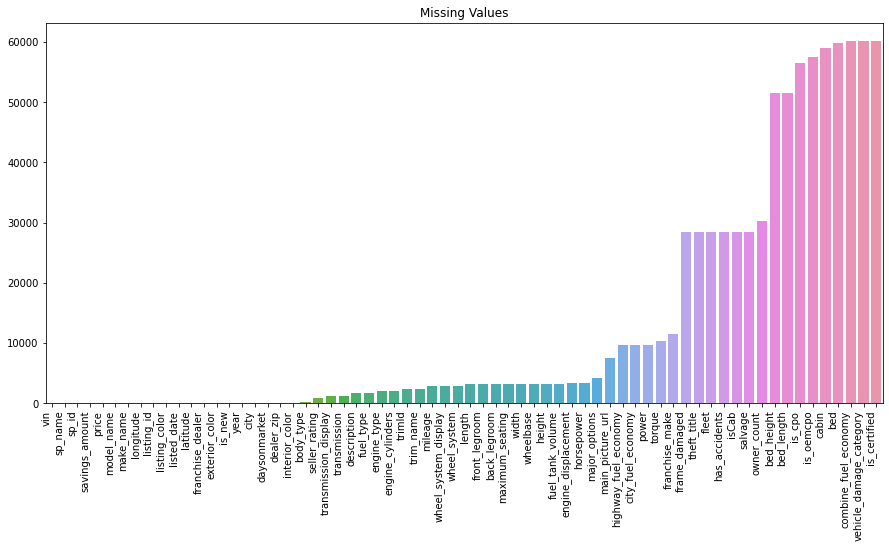

In [50]:
# Plotting the columns with missing values
x_val = used_data.isnull().sum().sort_values(ascending=True).index
y_val = used_data.isnull().sum().sort_values(ascending=True).values
plt.figure(figsize=(15,7))
sns.barplot(x_val,y_val)
plt.xticks(rotation=90, horizontalalignment="right")
plt.title("Missing Values")
plt.show()